In [1]:
pip install torch torchvision torchaudio


Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms


transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)  # torch.Size([64, 1, 28, 28])


torch.Size([64, 1, 28, 28])


In [3]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128) 
        self.fc2 = nn.Linear(128, 10)  

    def forward(self, x):
        x = x.view(-1, 28 * 28) 
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x)  
        return x

net = Net()
print(net)


Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [4]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer (two choices)

#optimizer = optim.SGD(net.parameters(), lr=0.001)
optimizer = optim.Adam(net.parameters(), lr=0.001519)


In [5]:
## Model training 

for epoch in range(20):  
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()  
        outputs = net(images) 
        loss = criterion(outputs, labels) 
        loss.backward()  
        optimizer.step() 
        
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}")

print("Training done!")


Epoch 1, Loss: 0.29374705718905686
Epoch 2, Loss: 0.12485233447583977
Epoch 3, Loss: 0.08447416520107594
Epoch 4, Loss: 0.06476333902340566
Epoch 5, Loss: 0.04885843119781111
Epoch 6, Loss: 0.03887961200226956
Epoch 7, Loss: 0.03155616199184926
Epoch 8, Loss: 0.02454531927297546
Epoch 9, Loss: 0.020590136753646397
Epoch 10, Loss: 0.01720235491183766
Epoch 11, Loss: 0.013973151356559436
Epoch 12, Loss: 0.013578504067687402
Epoch 13, Loss: 0.012479609286551972
Epoch 14, Loss: 0.011054447209456008
Epoch 15, Loss: 0.00864400095743127
Epoch 16, Loss: 0.007220999589218743
Epoch 17, Loss: 0.006531571496487577
Epoch 18, Loss: 0.008015120644278353
Epoch 19, Loss: 0.00647923827410389
Epoch 20, Loss: 0.0050540081484368995
Training done!


In [6]:
correct = 0
total = 0

with torch.no_grad():  
    for images, labels in testloader:
        outputs = net(images)  
        _, predicted = torch.max(outputs, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")


Accuracy: 97.85%


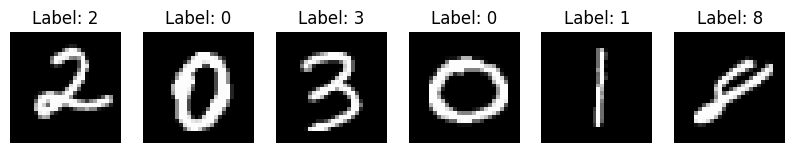

In [7]:
import matplotlib.pyplot as plt
import numpy as np


dataiter = iter(trainloader)
images, labels = next(dataiter)

# First six pictures
fig, axes = plt.subplots(1, 6, figsize=(10, 3))
for i in range(6):
    axes[i].imshow(images[i].numpy().squeeze(), cmap="gray")
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis("off")
plt.show()



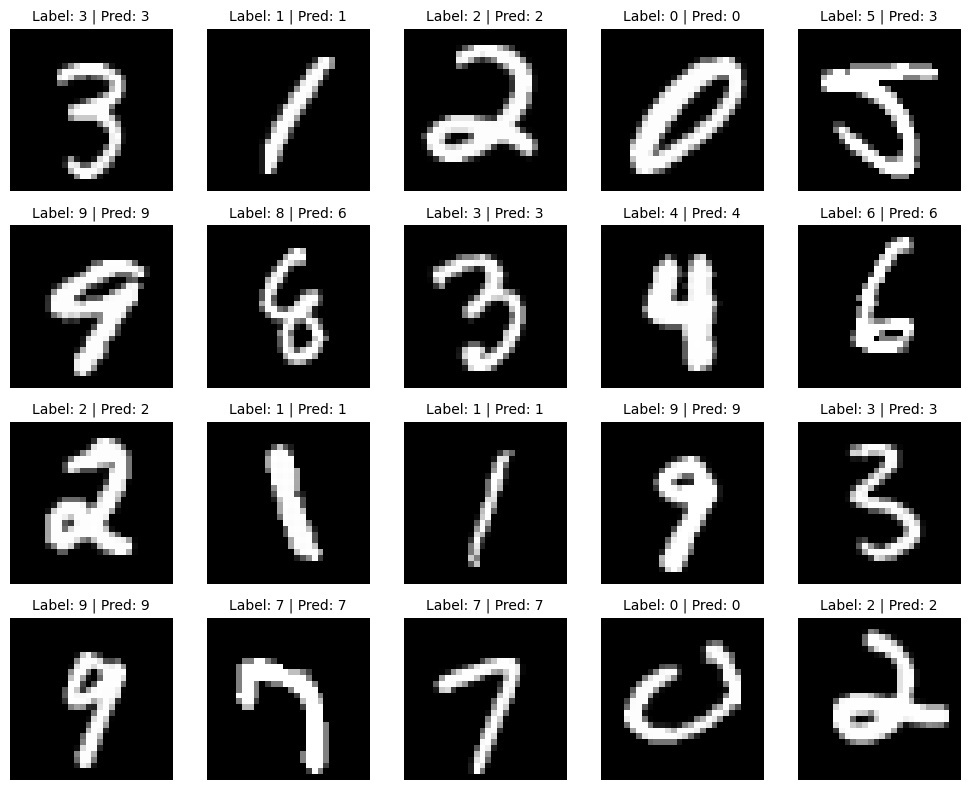

In [8]:
## Test

import random
import torch
import matplotlib.pyplot as plt

# randomly select 20 samples
num_samples = 20
indices = random.sample(range(len(testset)), num_samples)  
images, labels = zip(*[testset[i] for i in indices])  

# prediction
with torch.no_grad():
    outputs = net(torch.stack([img.view(-1, 28 * 28) for img in images]))  
    _, predicted = torch.max(outputs, 1)  

# Plot
fig, axes = plt.subplots(4, 5, figsize=(10, 8))  
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap="gray")  
    ax.set_title(f"Label: {labels[i]} | Pred: {predicted[i].item()}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()


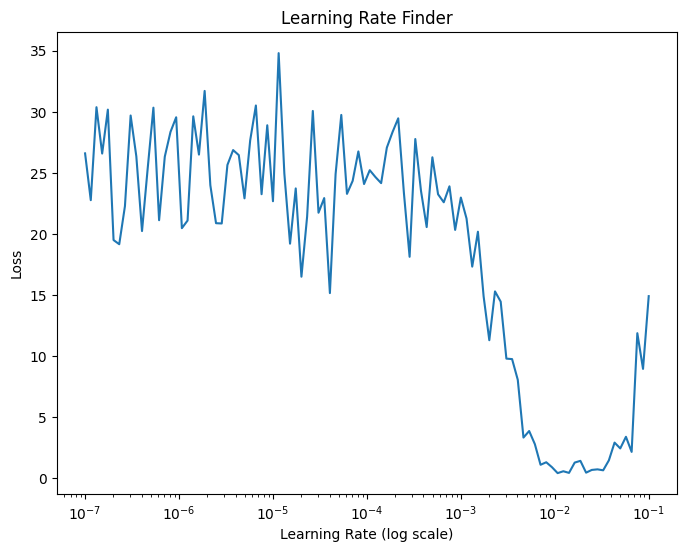

Optimal learning rate: 1.3219411484660286e-05
Suggested minimum learning rate: 1.3219411484660286e-06
Suggested maximum learning rate: 1.3219411484660286e-05


In [10]:
import matplotlib.pyplot as plt
import numpy as np
lr_list = np.logspace(-7, -1, 100)  
losses = []


for lr in lr_list:
    optimizer = optim.Adam(net.parameters(), lr=lr)
    images, labels = next(iter(trainloader))  
    optimizer.zero_grad()
    outputs = net(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# lr vs loss plot
plt.figure(figsize=(8,6))
plt.plot(lr_list, losses)
plt.xscale('log')  
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Loss")
plt.title("Learning Rate Finder")
plt.show()


loss_diff = np.gradient(losses)  
lr_best_index = np.argmin(loss_diff) 
lr_best = lr_list[lr_best_index]  

print(f"Optimal learning rate: {lr_best}")





loss_diff = np.gradient(losses)  
lr_max_index = np.argmin(loss_diff) 
lr_max = lr_list[lr_max_index] 

#  lr_min (1/10 of lr_max)
lr_min = lr_max / 10

print(f"Suggested minimum learning rate: {lr_min}")
print(f"Suggested maximum learning rate: {lr_max}")


In [11]:
## MNIST revisit ##


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
input_size = 28      # For RNN/ESN: input is a row of pixels
sequence_length = 28 # 28 rows per image
hidden_size = 64
reservoir_size = 100
num_layers = 1
num_classes = 10
batch_size = 64
num_epochs = 2
learning_rate = 0.001

# MNIST dataset
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# FNN model
class FNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_size * sequence_length, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.reshape(-1, input_size * sequence_length)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# RNN/LSTM/GRU unified model
class RNN_Model(nn.Module):
    def __init__(self, mode='RNN'):
        super(RNN_Model, self).__init__()
        if mode == 'RNN':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        elif mode == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        elif mode == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.mode = mode
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        if self.mode == 'LSTM':
            out, _ = self.rnn(x)
        else:
            out, _ = self.rnn(x, None)
        out = self.fc(out[:, -1, :])
        return out

    
    
    
# Basic ESN encoder
class ESN(nn.Module):
    def __init__(self, input_size, reservoir_size, spectral_radius=0.95, leaking_rate=0.2, input_scale=0.1):
        super().__init__()
        self.reservoir_size = reservoir_size
        self.leaking_rate = leaking_rate
        
        # W_in
        self.W_in = nn.Parameter(torch.randn(reservoir_size, input_size) * input_scale, requires_grad=True)

        # Bias 
        self.bias = nn.Parameter(torch.zeros(reservoir_size), requires_grad=True)

        # Reservoir weights 
        W = torch.randn(reservoir_size, reservoir_size)
        eigvals = torch.linalg.eigvals(W).abs()
        W = W * (spectral_radius / eigvals.max())
        self.W = nn.Parameter(W, requires_grad=False)

    def forward(self, x):
        
        batch_size = x.size(0)
        x = x.squeeze(1) if x.dim() == 4 else x
        h = torch.zeros(batch_size, self.reservoir_size, device=x.device)

        for t in range(x.size(1)):
            u = x[:, t, :]
            preact = F.linear(u, self.W_in) + F.linear(h, self.W) + self.bias
            new_h = torch.tanh(preact)
            h = (1 - self.leaking_rate) * h + self.leaking_rate * new_h

        return h 

class ESNClassifier(nn.Module):
    def __init__(self, input_size, reservoir_size, output_size, spectral_radius=0.95, leaking_rate=0.2, input_scale=0.1):
        super().__init__()
        self.encoder = ESN(input_size, reservoir_size, spectral_radius, leaking_rate, input_scale)
        self.readout = nn.Linear(reservoir_size, output_size)

    def forward(self, x):
        h = self.encoder(x)  
        return self.readout(h)  


# Training and evaluation functions
def train(model, loader, criterion, optimizer, model_name=''):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            if model_name in ['RNN', 'LSTM', 'GRU', 'ESN']:
                images = images.squeeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"{model_name} Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

def evaluate(model, loader, model_name=''):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            if model_name in ['RNN', 'LSTM', 'GRU', 'ESN']:
                images = images.squeeze(1)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f"{model_name} Accuracy: {acc:.2f}%\n")
    return acc

# All models
models = {
    'FNN': FNN(input_size, hidden_size, num_classes).to(device),
    'RNN': RNN_Model('RNN').to(device),
    'LSTM': RNN_Model('LSTM').to(device),
    'GRU': RNN_Model('GRU').to(device),
    'ESN': ESNClassifier(input_size=28, reservoir_size=500, output_size=10).to(device)
}

for name, model in models.items():
    print(f"Training {name}...")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) if name != 'ESN' else torch.optim.Adam(model.readout.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    train(model, train_loader, criterion, optimizer, name)
    evaluate(model, test_loader, name)


Training FNN...
FNN Epoch [1/2], Loss: 365.9649
FNN Epoch [2/2], Loss: 181.1698
FNN Accuracy: 95.43%

Training RNN...
RNN Epoch [1/2], Loss: 861.5661
RNN Epoch [2/2], Loss: 436.1662
RNN Accuracy: 88.90%

Training LSTM...
LSTM Epoch [1/2], Loss: 537.2346
LSTM Epoch [2/2], Loss: 176.1201
LSTM Accuracy: 95.15%

Training GRU...
GRU Epoch [1/2], Loss: 639.7835
GRU Epoch [2/2], Loss: 197.5640
GRU Accuracy: 95.64%

Training ESN...
ESN Epoch [1/2], Loss: 1351.7092
ESN Epoch [2/2], Loss: 1001.2443
ESN Accuracy: 71.41%

